<a href="https://colab.research.google.com/github/leonellielena/Food_webs_patterns/blob/main/Camacho.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.special import exp1, gammainc, gammaincc, gammainccinv

In [ ]:
import networkx as nx
from networkx.convert_matrix import from_numpy_array

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Functions

In [ ]:
class Food_Web:

  def __init__(self, name, matrix):
    self.name = name
    self.matrix = matrix 
    self.S = matrix.shape[0]
    self.L = self.matrix.sum()
    self.z = self.L / self.S
    self.cannibals = np.trace(self.matrix)
    self.d = np.mean(nx.floyd_warshall_numpy(nx.from_numpy_array(self.matrix)))
    self.C = np.mean(list(nx.clustering(nx.from_numpy_array(self.matrix)).values()))
    self.preys = np.sum(self.matrix,axis=0)
    self.pred = np.sum(self.matrix,axis=1)


  def preys_cumulative(self):
    preys=np.sum(self.matrix,axis=0)
    preys_val, preys_count = np.unique(preys,return_counts = True)

    return [preys_val, 1-np.cumsum(preys_count/np.sum(preys_count)) + preys_count/np.sum(preys_count) ]


  def pred_cumulative(self):
    pred=np.sum(self.matrix,axis=1)
    pred_val, pred_count = np.unique(pred,return_counts = True)

    return [pred_val , 1-np.cumsum(pred_count/np.sum(pred_count)) + pred_count/np.sum(pred_count) ]



In [ ]:
# k is an array
def cum_prey_th (k,z):
  distr = np.exp(- 0.5*k/z) - (0.5*k/z)*exp1(0.5*k/z)
  return distr

def cum_pred_th (m,z):
  results = []
  gammas = (1/(2*z))*gammainc((m+1), 2*z)
  for i in range(len(m)):
    results.append(np.sum(gammas[i:])) 
  return  np.array(results)/results[0]


def pred_th (m,z):
  gammas = gammainc((m+1), 2*z)
  return  gammas

def prey_th (k,z):
  distr = exp1(0.5*k/z)
  return distr

# Niche model simulations



1.   assign to $S_i$ his trophic niche $n_i$ by sampling in $[0,1]$
2.   for each $i$, select $x$ randomly from pdf $p_x(x)=b(1-x)^{b-1}$,

 where $b= \frac{S}{2z}-1$
3.   choose a position $a$ at randomly in the interval $[\frac{xn_i}{2},n_i]$
4.   if $n_j$ is inside a segment $xn_i$ centered in $a$, $i$ preys $j$



In [ ]:
from numba import njit

In [ ]:
@njit
def trophically_identical(matrix):

  S=matrix.shape[0]

  intersection = np.zeros(S,dtype='int64')

  for i in np.where(intersection==0)[0]:
    for j in range(i+1,S):
      if np.all(matrix[i,:]==matrix[j,:]) and np.all(matrix[:,i]==matrix[:,j]):

        #se sono uguali sia le righe che le colonne
        intersection[j]=1

  #check disconnected
  for k in range(S):
    if np.all(matrix[i,:] == np.zeros(S)) and np.all(matrix[:,i] == np.zeros(S)):
      intersection[i]=1

  return np.where(intersection!=0)[0]
        


In [ ]:

@njit
def matrix(S,z,trophic_niches,lows, highs):
  matrix = np.zeros((S,S),dtype='int64')

  #beta = 0.5*S/z -2 
  #r = np.random.beta(a=1,b=beta,size=S)*trophic_niches*0.5
  #r = r.astype('float64')
  
  #r = getRandBeta(beta,S)*trophic_niches
  

  #basal species
  #basal = np.where(trophic_niches == trophic_niches.min())[0].astype('int64')
  #r[basal] = 0

  #centers = np.random.rand(S)*(trophic_niches-r)+r
  #centers = centers.astype('float64')
  #centers = getRandUn(low=0.5*r,high=trophic_niches,n=S)

  #lows = centers-r
  #highs = centers+r

  for i in range(S):
    preys = np.where((trophic_niches<=highs[i]) & (trophic_niches>=lows[i]))[0]
    #riempio la colonna i con degli 1 in corrispondenza delle prede
    matrix[preys,i] = 1

  basal = np.where(trophic_niches == trophic_niches.min())[0].astype('int64')
  matrix[:,basal] = 0

  return matrix.astype('int64')


@njit
def niche(S,z):
  trophic_niches = np.random.rand(S).astype('float64')

  beta = 0.5*S/z -2 
  r = (np.random.beta(a=1,b=beta,size=S)*trophic_niches*0.5).astype('float64')

  # basal = np.where(trophic_niches == trophic_niches.min())[0].astype('int64')
  # r[basal] = 0

  centers = np.random.rand(S)*(trophic_niches-r)+r
  centers = centers.astype('float64')

  lows = centers-r
  highs = centers+r

  web_matrix = matrix(S,z,trophic_niches,lows,highs)

  '''
  Occasionally, model-generated webs contain completely disconnected
  species or trophically identical species. Such species are eliminated and replaced
  until the web is free of such species. The species with the smallest ni has rI = 0 so that
  every web has at least one basal species.
  '''
  '''
  #check disconnected species
  for i in range(S):
    if np.all(web_matrix[i,:] == np.zeros(S)) and np.all(web_matrix[:,i] == np.zeros(S)):
      #replace with a new one!
      trophic_niches[i] = np.random.rand(1)[0]
      web_matrix = matrix(S,z,trophic_niches.astype('float64')) #new matrix if needed
  '''

  #check trophically identical species
  check_troph = trophically_identical(web_matrix.astype('int64'))

  while check_troph.shape[0] != 0:
    #print(check_troph.shape[0])
    #ricalcolo trophic niches e rimando la matrice
    tmp_size = check_troph.shape[0]
    trophic_niches[check_troph] = np.random.rand(tmp_size).astype('float64')
    r[check_troph] = (np.random.beta(a=1,b=beta,size=tmp_size)*trophic_niches[check_troph]*0.5).astype('float64')

    centers[check_troph] = (np.random.rand(tmp_size)*(trophic_niches[check_troph]-r[check_troph])+r[check_troph]).astype('float64')

    lows[check_troph] = centers[check_troph]-r[check_troph]
    highs[check_troph] = centers[check_troph]+r[check_troph]

    web_matrix = matrix(S,z,trophic_niches,lows,highs) #new matrix if needed
    check_troph = trophically_identical(web_matrix.astype('int64'))
    #print(check_troph)


  return web_matrix.astype('int64')



# Random model simulation
with parameters S and $z=\frac{L}{S}$ linkage density

In [ ]:
# a link between species occur with probability C=L/s**2
def random_model(S,C):
  #C = L/S**2
  matrix = np.zeros((S,S))
  for i in range(S):
    for j in range(S):
      a = np.random.uniform(0,1)
      if a<=C:
        matrix[i,j] = 1
  
  return matrix

# Empirical data

| Web         | taxa | S | exp. taxa | exp. S |
|--------------|:-----:|:-----:|:-----:|:-----:|
| **Bridge Brook Lake** |75|25|75|25|
| **Coachella Valley**  |30|29|30|29|
| Chesapeake Bay |36|25|33|31|
| Little Rock Lake  |182|93|181|92|
| **Skipwith Pond** |35|25|35|25|
| **St. Martin Island**  |44|42|44|42|
| **Ythan Estuary** |92|78|92|78|

In [ ]:
web_brook = pd.read_csv('https://raw.githubusercontent.com/leonellielena/Food_webs_patterns/main/bridge_brook.csv',header=None).to_numpy()
web_chesapeake = pd.read_csv('https://raw.githubusercontent.com/leonellielena/Food_webs_patterns/main/chesapeake_39.csv',header=None).to_numpy()
web_coachella= pd.read_csv('https://raw.githubusercontent.com/leonellielena/Food_webs_patterns/main/coachella.csv',header=None).to_numpy()
web_skipwith= pd.read_csv('https://raw.githubusercontent.com/leonellielena/Food_webs_patterns/main/skipwith.csv',header=None).to_numpy()
web_ythan= pd.read_csv('https://raw.githubusercontent.com/leonellielena/Food_webs_patterns/main/ythan.csv',header=None).to_numpy()
web_rock= pd.read_csv('https://raw.githubusercontent.com/leonellielena/Food_webs_patterns/main/little_rock.csv',header=None).to_numpy()
web_martin= pd.read_csv('https://raw.githubusercontent.com/leonellielena/Food_webs_patterns/main/st_martin.csv',header=None).to_numpy()


In [ ]:
#new datasets
web_itaipu = pd.read_csv('https://raw.githubusercontent.com/leonellielena/Food_webs_patterns/main/fw_004.csv',header=None).to_numpy()
web_caribbean = pd.read_csv('https://raw.githubusercontent.com/leonellielena/Food_webs_patterns/main/fw_008.csv',header=None).to_numpy()
web_maine = pd.read_csv('https://raw.githubusercontent.com/leonellielena/Food_webs_patterns/main/fw_011.csv',header=None).to_numpy()

In [ ]:
brook = Food_Web('Bridge Brook',web_brook)
chesapeake = Food_Web('Chesapeake',web_chesapeake)
coachella = Food_Web('Coachella',web_coachella)
skipwith = Food_Web('Skipwith',web_skipwith)
ythan = Food_Web('Ythan',web_ythan)
rock = Food_Web('Little Rock',web_rock)
martin = Food_Web('St Martin',web_martin)

itaipu = Food_Web('Itaipu', web_itaipu)
caribbean = Food_Web('Caribbean', web_caribbean)
maine = Food_Web('Maine', web_maine)

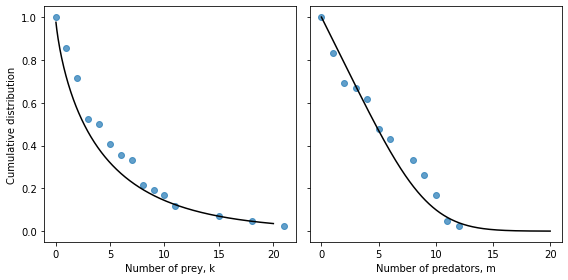

In [ ]:
xs = np.linspace(0,20,500)

fig, axs = plt.subplots(1,2,figsize=(8,4),sharey=True)
counts,bins = np.histogram(martin.preys,bins=10,density=True)
counts1,bins1 = np.histogram(martin.pred,bins=10,density=True)

counts = np.cumsum(counts[::-1])[::-1] /np.sum(counts)

#axs[0].plot(bins[:-1],counts,'o',alpha=0.5)
axs[0].plot(martin.preys_cumulative()[0],martin.preys_cumulative()[1],'o',alpha=0.7)
axs[0].plot(xs,cum_prey_th(xs,martin.z),color='black')
axs[0].set_xlabel('Number of prey, k')
axs[0].set_ylabel('Cumulative distribution')
#axs[0].set_xlim(0,20)
#axs[0].set_ylim(0,1)

#axs[1].plot(0.5*(bins1[0:-1]+bins1[1:]),counts1,'o',alpha=0.5)
axs[1].plot(martin.pred_cumulative()[0],martin.pred_cumulative()[1],'o',alpha=0.7)
axs[1].plot(xs,cum_pred_th(xs,martin.z),color='black')
axs[1].set_xlabel('Number of predators, m')
#axs[1].set_xlim(0,20)

fig.tight_layout()
fig.savefig('Fig1.pdf')
plt.show()

## Fig 2

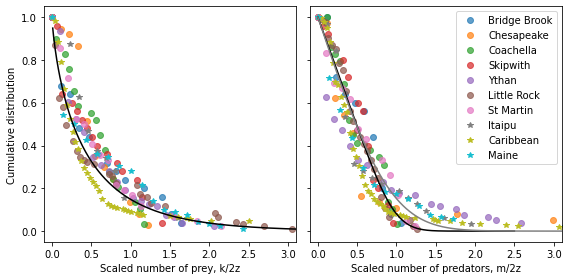

In [ ]:
xs = np.linspace(0,50,500)

fig, axs = plt.subplots(1,2,figsize=(8,4),sharey=True)

axs[0].plot(brook.preys_cumulative()[0]*0.5/brook.z,brook.preys_cumulative()[1],'o',label=brook.name,alpha=0.7)
axs[0].plot(chesapeake.preys_cumulative()[0]*0.5/chesapeake.z,chesapeake.preys_cumulative()[1],'o',label=chesapeake.name,alpha=0.7)
axs[0].plot(coachella.preys_cumulative()[0]*0.5/coachella.z,coachella.preys_cumulative()[1],'o',label=coachella.name,alpha=0.7)
axs[0].plot(skipwith.preys_cumulative()[0]*0.5/skipwith.z,skipwith.preys_cumulative()[1],'o',label=skipwith.name,alpha=0.7)
axs[0].plot(ythan.preys_cumulative()[0]*0.5/ythan.z,ythan.preys_cumulative()[1],'o',label=ythan.name,alpha=0.7)
axs[0].plot(rock.preys_cumulative()[0]*0.5/rock.z,rock.preys_cumulative()[1],'o',label=rock.name,alpha=0.7)
axs[0].plot(martin.preys_cumulative()[0]*0.5/martin.z,martin.preys_cumulative()[1],'o',label=martin.name,alpha=0.7)

axs[0].plot(itaipu.preys_cumulative()[0]*0.5/itaipu.z,itaipu.preys_cumulative()[1],'*',label=itaipu.name)
axs[0].plot(caribbean.preys_cumulative()[0]*0.5/caribbean.z,caribbean.preys_cumulative()[1],'*',label=caribbean.name)
axs[0].plot(maine.preys_cumulative()[0]*0.5/maine.z,maine.preys_cumulative()[1],'*',label=maine.name)

axs[0].plot(xs*0.5/martin.z,cum_prey_th(xs,martin.z),color='black')

axs[0].set_xlabel('Scaled number of prey, k/2z')
axs[0].set_ylabel('Cumulative distribution')
axs[0].set_xlim(-0.1,3.1)

axs[1].plot(brook.pred_cumulative()[0]*0.5/brook.z,brook.pred_cumulative()[1],'o',label=brook.name,alpha=0.7)
axs[1].plot(chesapeake.pred_cumulative()[0]*0.5/chesapeake.z,chesapeake.pred_cumulative()[1],'o',label=chesapeake.name,alpha=0.7)
axs[1].plot(coachella.pred_cumulative()[0]*0.5/coachella.z,coachella.pred_cumulative()[1],'o',label=coachella.name,alpha=0.7)
axs[1].plot(skipwith.pred_cumulative()[0]*0.5/skipwith.z,skipwith.pred_cumulative()[1],'o',label=skipwith.name,alpha=0.7)
axs[1].plot(ythan.pred_cumulative()[0]*0.5/ythan.z,ythan.pred_cumulative()[1],'o',label=ythan.name,alpha=0.7)
axs[1].plot(rock.pred_cumulative()[0]*0.5/rock.z,rock.pred_cumulative()[1],'o',label=rock.name,alpha=0.7)
axs[1].plot(martin.pred_cumulative()[0]*0.5/martin.z,martin.pred_cumulative()[1],'o',label=martin.name,alpha=0.7)

axs[1].plot(itaipu.pred_cumulative()[0]*0.5/itaipu.z,itaipu.pred_cumulative()[1],'*',label=itaipu.name)
axs[1].plot(caribbean.pred_cumulative()[0]*0.5/caribbean.z,caribbean.pred_cumulative()[1],'*',label=caribbean.name)
axs[1].plot(maine.pred_cumulative()[0]*0.5/maine.z,maine.pred_cumulative()[1],'*',label=maine.name)

axs[1].plot(xs*0.5/10,cum_pred_th(xs,10),color='black')
axs[1].plot(xs*0.5/2.5,cum_pred_th(xs,2.5),color='grey')

axs[1].set_xlabel('Scaled number of predators, m/2z')
axs[1].set_xlim(-0.1,3.1)

plt.legend()
fig.tight_layout()
fig.savefig('Fig2a_2.pdf')
plt.show()

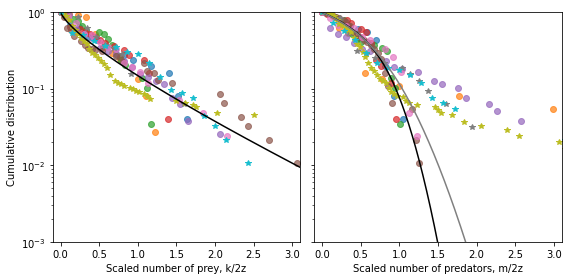

In [ ]:
xs = np.linspace(0,50,500)

fig, axs = plt.subplots(1,2,figsize=(8,4),sharey=True)

axs[0].plot(brook.preys_cumulative()[0]*0.5/brook.z,brook.preys_cumulative()[1],'o',label=brook.name,alpha=0.7)
axs[0].plot(chesapeake.preys_cumulative()[0]*0.5/chesapeake.z,chesapeake.preys_cumulative()[1],'o',label=chesapeake.name,alpha=0.7)
axs[0].plot(coachella.preys_cumulative()[0]*0.5/coachella.z,coachella.preys_cumulative()[1],'o',label=coachella.name,alpha=0.7)
axs[0].plot(skipwith.preys_cumulative()[0]*0.5/skipwith.z,skipwith.preys_cumulative()[1],'o',label=skipwith.name,alpha=0.7)
axs[0].plot(ythan.preys_cumulative()[0]*0.5/ythan.z,ythan.preys_cumulative()[1],'o',label=ythan.name,alpha=0.7)
axs[0].plot(rock.preys_cumulative()[0]*0.5/rock.z,rock.preys_cumulative()[1],'o',label=rock.name,alpha=0.7)
axs[0].plot(martin.preys_cumulative()[0]*0.5/martin.z,martin.preys_cumulative()[1],'o',label=martin.name,alpha=0.7)

axs[0].plot(itaipu.preys_cumulative()[0]*0.5/itaipu.z,itaipu.preys_cumulative()[1],'*',label=itaipu.name)
axs[0].plot(caribbean.preys_cumulative()[0]*0.5/caribbean.z,caribbean.preys_cumulative()[1],'*',label=caribbean.name)
axs[0].plot(maine.preys_cumulative()[0]*0.5/maine.z,maine.preys_cumulative()[1],'*',label=maine.name)

axs[0].plot(xs*0.5/martin.z,cum_prey_th(xs,martin.z),color='black')

axs[0].set_xlabel('Scaled number of prey, k/2z')
axs[0].set_ylabel('Cumulative distribution')
axs[0].set_xlim(-0.1,3.1)
axs[0].set_yscale('log')
axs[0].set_ylim(10**(-3),1)


axs[1].plot(brook.pred_cumulative()[0]*0.5/brook.z,brook.pred_cumulative()[1],'o',label=brook.name,alpha=0.7)
axs[1].plot(chesapeake.pred_cumulative()[0]*0.5/chesapeake.z,chesapeake.pred_cumulative()[1],'o',label=chesapeake.name,alpha=0.7)
axs[1].plot(coachella.pred_cumulative()[0]*0.5/coachella.z,coachella.pred_cumulative()[1],'o',label=coachella.name,alpha=0.7)
axs[1].plot(skipwith.pred_cumulative()[0]*0.5/skipwith.z,skipwith.pred_cumulative()[1],'o',label=skipwith.name,alpha=0.7)
axs[1].plot(ythan.pred_cumulative()[0]*0.5/ythan.z,ythan.pred_cumulative()[1],'o',label=ythan.name,alpha=0.7)
axs[1].plot(rock.pred_cumulative()[0]*0.5/rock.z,rock.pred_cumulative()[1],'o',label=rock.name,alpha=0.7)
axs[1].plot(martin.pred_cumulative()[0]*0.5/martin.z,martin.pred_cumulative()[1],'o',label=martin.name,alpha=0.7)

axs[1].plot(itaipu.pred_cumulative()[0]*0.5/itaipu.z,itaipu.pred_cumulative()[1],'*',label=itaipu.name)
axs[1].plot(caribbean.pred_cumulative()[0]*0.5/caribbean.z,caribbean.pred_cumulative()[1],'*',label=caribbean.name)
axs[1].plot(maine.pred_cumulative()[0]*0.5/maine.z,maine.pred_cumulative()[1],'*',label=maine.name)

axs[1].plot(xs*0.5/11,cum_pred_th(xs,11),color='black')
axs[1].plot(xs*0.5/4.5,cum_pred_th(xs,4.5),color='grey')
#axs[1].plot(xs*0.5/10,cum_pred_th(xs,10))
#axs[1].plot(xs*0.5/2.5,cum_pred_th(xs,2.5))

axs[1].set_xlabel('Scaled number of predators, m/2z')
axs[1].set_xlim(-0.1,3.1)

#axs[0].legend(loc='bottom left')
fig.tight_layout()
fig.savefig('Fig2b_2.pdf')
plt.show()

# All datasets together

In [ ]:
#Niche model simulation with S= S_tot and z=mean_z

S_tot = np.sum([brook.S,chesapeake.S,coachella.S,skipwith.S,rock.S,martin.S,ythan.S,itaipu.S,caribbean.S,maine.S])
mean_z = np.mean([brook.z,chesapeake.z,coachella.z,skipwith.z,rock.z,martin.z,ythan.z,itaipu.z,caribbean.z,maine.z])

print(S_tot,mean_z)

698 6.772676349066704


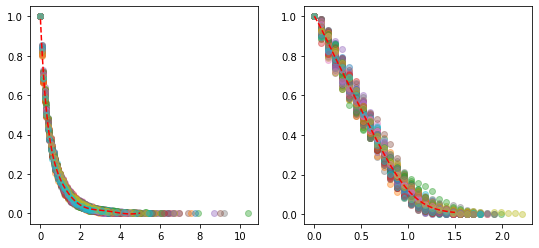

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(9,4))
xdata_preys = np.array([])
ydata_preys = np.array([])
xdata_pred = np.array([])
ydata_pred = np.array([])


for i in range(100):

  matrix = niche(S_tot,mean_z)
  m = Food_Web('',matrix)

  a = m.preys_cumulative()[0]*0.5/mean_z
  b = m.preys_cumulative()[1]
  c = m.pred_cumulative()[0]*0.5/mean_z
  d = m.pred_cumulative()[1]

  xdata_preys=np.concatenate([xdata_preys,a])
  ydata_preys=np.concatenate([ydata_preys,b])
  xdata_pred=np.concatenate([xdata_pred,c])
  ydata_pred=np.concatenate([ydata_pred,d])

  axs[0].plot(a,b,'o',alpha=0.4)
  axs[1].plot(c,d,'o',alpha=0.4)


coefs = np.polyfit(xdata_preys, ydata_preys, deg=10)
poly = np.poly1d(coefs)

xvals = np.linspace(0,5,100)
axs[0].plot(xvals,poly(xvals),'--',color='red')

coefs2 = np.polyfit(xdata_pred, ydata_pred, deg=10)
poly2 = np.poly1d(coefs2)

xvals2 = np.linspace(0,1.5,100)
axs[1].plot(xvals2,poly2(xvals2),'--',color='red')


plt.show()


In [ ]:
total_preys = 0.5*np.concatenate([brook.preys/brook.z,chesapeake.preys/chesapeake.z,coachella.preys/coachella.z,skipwith.preys/skipwith.z,
                                  rock.preys/rock.z,martin.preys/martin.z,ythan.preys/ythan.z])#,itaipu.preys/itaipu.z,
                                  #caribbean.preys/caribbean.z,maine.preys/maine.z])
total_pred = 0.5*np.concatenate([brook.pred/brook.z,chesapeake.pred/chesapeake.z,coachella.pred/coachella.z,skipwith.pred/skipwith.z,
                                 rock.pred/rock.z,martin.pred/martin.z,ythan.pred/ythan.z])#,itaipu.pred/itaipu.z,
                                 #caribbean.pred/caribbean.z,maine.pred/maine.z])

total_preys_val, total_preys_count = np.unique(total_preys,return_counts = True)
cum_preys = 1-np.cumsum(total_preys_count/np.sum(total_preys_count)) + total_preys_count/np.sum(total_preys_count)

total_pred_val, total_pred_count = np.unique(total_pred,return_counts = True)
cum_pred = 1-np.cumsum(total_pred_count/np.sum(total_pred_count)) + total_pred_count/np.sum(total_pred_count)

total_r = total_preys+total_pred #elementwise

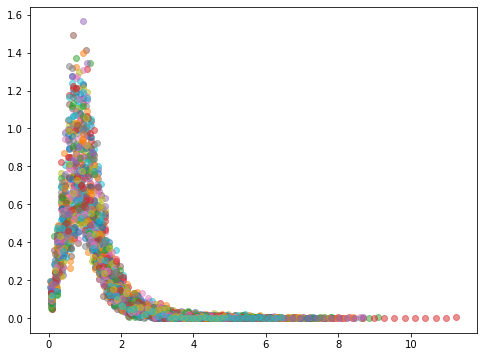

In [ ]:
#niche S=1000, z=5
r_sim = np.array([])

fig,ax = plt.subplots(1,1,figsize=(8,6))

for i in range(100):

  matrix = niche(1000,5.)
  #m = Food_Web('',matrix)
  data = (np.sum(matrix,axis=0)+np.sum(matrix,axis=1))/10 #(m.preys + m.pred)/10

  r_sim = np.concatenate([r_sim,data])
  
  counts_r,bins_r = np.histogram(data,bins=40,density=True)

  ax.plot(0.5*(bins_r[0:-1]+bins_r[1:]),counts_r,'o',alpha=0.5)


counts_tot,bins_tot = np.histogram(r_sim,bins=40,density=True)


plt.show()


In [ ]:
counts_tot,bins_tot = np.histogram(r_sim,bins=30,density=True)

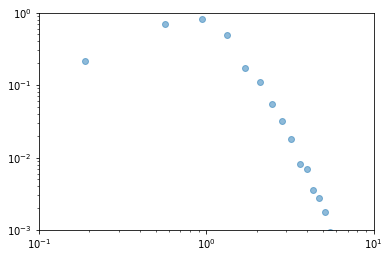

In [ ]:
xvals = np.linspace(0,8,300)
plt.plot(0.5*(bins_tot[0:-1]+bins_tot[1:]),counts_tot,'o',alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlim(10**(-1),10)
plt.ylim(10**(-3),1)
plt.show()

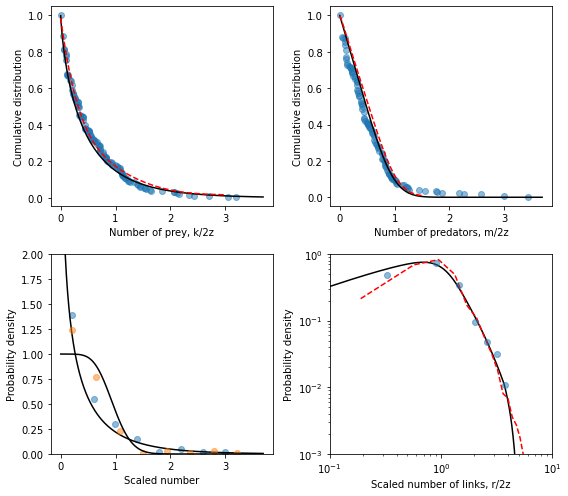

In [ ]:
#FIG.3
#a and b: cumulative d.f. of scaled number of preys/pred

fig,ax = plt.subplots(2,2,figsize=(8,7))

xs = np.linspace(0.001,50,500)
xvals = np.linspace(0,3,100)
xvals2 = np.linspace(0,1.5,100)

ax[0,0].plot(total_preys_val,cum_preys,'o',alpha=0.5)
ax[0,0].plot(xs*0.5/mean_z,cum_prey_th(xs,mean_z),'-',color='black')
ax[0,0].plot(xvals,poly(xvals),'--',color='red')
#ax[0].plot(0.5*itaipu.preys_cumulative()[0]/itaipu.z,itaipu.preys_cumulative()[1],'*')
ax[0,0].set_xlabel('Number of prey, k/2z')
ax[0,0].set_ylabel('Cumulative distribution')


ax[0,1].plot(total_pred_val,cum_pred,'o',alpha=0.5)
ax[0,1].plot(xs*0.5/mean_z,cum_pred_th(xs,mean_z),'-',color='black')
ax[0,1].plot(xvals2,poly2(xvals2),'--',color='red')
#ax[1].plot(0.5*itaipu.pred_cumulative()[0]/itaipu.z,itaipu.pred_cumulative()[1],'*')
ax[0,1].set_xlabel('Number of predators, m/2z')
ax[0,1].set_ylabel('Cumulative distribution')

counts_preys,bins_preys = np.histogram(total_preys,bins=8,density=True)
counts_pred,bins_pred = np.histogram(total_pred,bins=8,density=True)

ax[1,0].plot(0.5*(bins_preys[0:-1]+bins_preys[1:]),counts_preys,'o',alpha=0.5)
ax[1,0].plot(xs*0.5/mean_z,prey_th(xs,mean_z),'-',color='black')

ax[1,0].plot(0.5*(bins_pred[0:-1]+bins_pred[1:]),counts_pred,'o',alpha=0.5)
ax[1,0].plot(xs*0.5/mean_z,pred_th(xs,mean_z),'-',color='black')

ax[1,0].set_ylim(0,2)
ax[1,0].set_xlabel('Scaled number')
ax[1,0].set_ylabel('Probability density')


counts_r,bins_r = np.histogram(total_r,bins=7,density=True)

xs = np.linspace(0.001,50,500)
dd = np.convolve(pred_th(xs,mean_z),prey_th(xs,mean_z))
xvals = np.linspace(0.001,100,1000-1)#999 elements
#normalize dd
dd = dd*(xs[-1]-xs[0])*(0.5/mean_z)/500
ax[1,1].plot(xvals*0.5/mean_z,dd,color='black')

xvals = np.linspace(0,8,300)
ax[1,1].plot(0.5*(bins_tot[0:-1]+bins_tot[1:]),counts_tot,'--',color='red')
ax[1,1].plot(0.5*(bins_r[0:-1]+bins_r[1:]),counts_r,'o',alpha=0.5)

ax[1,1].set_xlim(10**(-1),10)
ax[1,1].set_ylim(10**(-3),1)
ax[1,1].set_xscale('log')
ax[1,1].set_yscale('log')
ax[1,1].set_xlabel('Scaled number of links, r/2z')
ax[1,1].set_ylabel('Probability density')


fig.tight_layout()
fig.savefig('Fig3.pdf')
plt.show()

# d and C

For the simulations, pay attention to:


*   $\beta = \frac{S}{2z}-2>0$
*   $L$ is an integer
*   $L$ must be large enough to make the algorithm converge (and smaller than $S^2$)



In [ ]:
from tqdm import tqdm

In [ ]:
def d_calc_sim(S,min,max,n=10,c=500):
  Lvalues = np.linspace(min,max,n,dtype='int64',endpoint=True)
  zvalues = Lvalues/S

  d_tmp = []
  a = np.log10(S)
  eff_z = []

  for z in tqdm(zvalues):
    tmp = []
    count = 0
    meansz = 0
    while count < c:
      m = niche(S,z)
      G = nx.from_numpy_array(m)

      if nx.is_connected(G):
        tmp.append(a/nx.average_shortest_path_length(G))
        count += 1
        meansz += np.sum(m)/S

    eff_z.append(meansz/c)

    d_tmp.append(tmp)

  return d_tmp,eff_z

In [ ]:
np.random.seed(42)
data_100_new,data_100_new_z=d_calc_sim(100,300,1200,n=5,c=100)

100%|██████████| 5/5 [00:15<00:00,  3.02s/it]


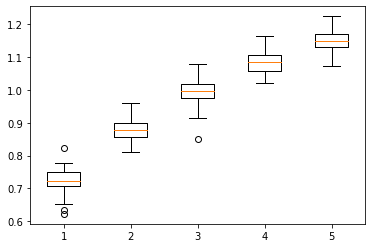

In [ ]:
plt.boxplot(data_100_new)
plt.show()

In [ ]:
np.random.seed(4682)
data_500_new,data_500_new_z=d_calc_sim(500,8000,20000,n=5,c=100)

100%|██████████| 5/5 [09:47<00:00, 117.44s/it]


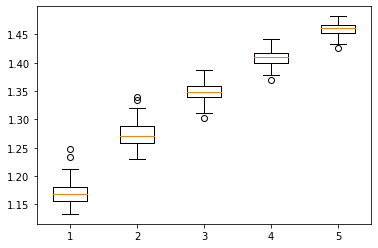

In [ ]:
plt.boxplot(data_500_new)
plt.show()

In [ ]:
np.random.seed(4682)
data_1000_new,data_1000_new_z=d_calc_sim(1000,12000,32000,n=5,c=100)

100%|██████████| 5/5 [43:49<00:00, 525.95s/it]


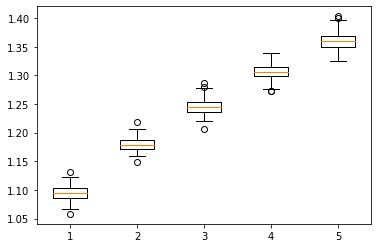

In [ ]:
plt.boxplot(data_1000_new)
plt.show()

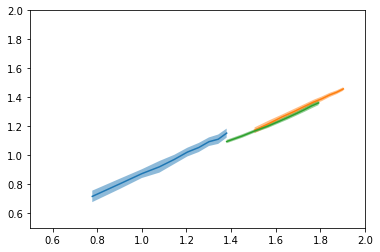

In [ ]:
#non serve questo
Lvalues = np.linspace(300,1200,10,dtype='int64',endpoint=True)
zvalues = Lvalues/100
data_100_new = np.array(data_100_new)

plt.plot(np.log10(2*zvalues),data_100_new.mean(axis=1))
y1 = data_100_new.mean(axis=1)+data_100_new.std(axis=1)
y2 = data_100_new.mean(axis=1)-data_100_new.std(axis=1)
plt.fill_between(np.log10(2*zvalues), y1, y2, alpha=.5, linewidth=0)



Lvalues = np.linspace(8000,20000,10,dtype='int64',endpoint=True)
zvalues = Lvalues/500
data_500_new = np.array(data_500_new)

plt.plot(np.log10(2*zvalues),data_500_new.mean(axis=1))
y1 = data_500_new.mean(axis=1)+data_500_new.std(axis=1)
y2 = data_500_new.mean(axis=1)-data_500_new.std(axis=1)
plt.fill_between(np.log10(2*zvalues), y1, y2, alpha=.5, linewidth=0)




Lvalues = np.linspace(12000,31000,10,dtype='int64',endpoint=True)
zvalues = Lvalues/1000
data_1000_new = np.array(data_1000_new)

plt.plot(np.log10(2*zvalues),data_1000_new.mean(axis=1))
y1 = data_1000_new.mean(axis=1)+data_1000_new.std(axis=1)
y2 = data_1000_new.mean(axis=1)-data_1000_new.std(axis=1)
plt.fill_between(np.log10(2*zvalues), y1, y2, alpha=.5, linewidth=0)



plt.xlim(0.5,2)
plt.ylim(0.5,2)
plt.show()

In [ ]:

all_means = np.concatenate((np.array(data_100_new).mean(axis=1),
                            np.array(data_500_new).mean(axis=1),
                            np.array(data_1000_new).mean(axis=1)))

In [ ]:
print(all_means)

[0.72404839 0.87871974 0.99437208 1.08301507 1.15060936 1.17162507
 1.27405682 1.34906574 1.40837212 1.45908617 1.09421348 1.17965736
 1.24550609 1.30738543 1.35938305]


In [ ]:

all_x_values = np.log10(2*np.concatenate((data_100_new_z,data_500_new_z,data_1000_new_z)))


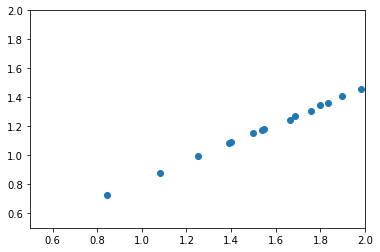

In [ ]:
plt.plot(all_x_values,all_means,'o')
plt.xlim(0.5,2)
plt.ylim(0.5,2)
plt.show()

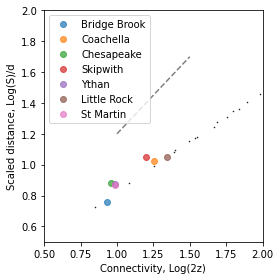

In [ ]:
plt.figure(figsize=(4,4))

plt.plot(np.log10(2*brook.z),np.log10(brook.S)/brook.d,'o',label=brook.name,alpha=0.7)
plt.plot(np.log10(2*coachella.z),np.log10(coachella.S)/coachella.d,'o',label=coachella.name,alpha=0.7)
plt.plot(np.log10(2*chesapeake.z),np.log10(chesapeake.S)/chesapeake.d,'o',label=chesapeake.name,alpha=0.7)
plt.plot(np.log10(2*skipwith.z),np.log10(skipwith.S)/skipwith.d,'o',label=skipwith.name,alpha=0.7)
plt.plot(np.log10(2*ythan.z),np.log10(ythan.S)/ythan.d,'o',label=ythan.name,alpha=0.7)
plt.plot(np.log10(2*rock.z),np.log10(rock.S)/rock.d,'o',label=rock.name,alpha=0.7)
plt.plot(np.log10(2*martin.z),np.log10(martin.S)/martin.d,'o',label=martin.name,alpha=0.7)

'''plt.plot(np.log10(2*itaipu.z),np.log10(itaipu.S)/itaipu.d,'*',label=itaipu.name,alpha=0.7)
plt.plot(np.log10(2*caribbean.z),np.log10(caribbean.S)/caribbean.d,'*',label=caribbean.name,alpha=0.7)
plt.plot(np.log10(2*maine.z),np.log10(maine.S)/maine.d,'*',label=maine.name,alpha=0.7)'''
plt.plot([1,1.5],[1.2,1.7],'--',color='grey')
plt.plot(all_x_values,all_means,'.',color='black',markersize=1)
plt.xlim(0.5,2)
plt.ylim(0.5,2)
plt.legend()

plt.xlabel('Connectivity, Log(2z)')
plt.ylabel('Scaled distance, Log(S)/d')

plt.tight_layout()
plt.savefig('Fig4a.pdf')
plt.show()

### C

In [ ]:
def C_calc_sim(z,min,max,n=10,c=100):
  Svalues = np.linspace(min,max,n,dtype='int64',endpoint=True)

  C_tmp = []
  eff_z = []

  for S in tqdm(Svalues):
    tmp = []
    count = 0
    meansz=0
    while count < c:
      m = niche(S,z)
      G = nx.from_numpy_array(m)

      #if nx.is_connected(G):
      tmp.append(np.mean(list(nx.clustering(G).values())))
      count += 1
      meansz += np.sum(m)/S

    eff_z.append(meansz/c)

    C_tmp.append(tmp)

  return C_tmp,eff_z

In [ ]:
np.random.seed(472)
C_25,C_25_z=C_calc_sim(2.5,30,200,n=5)
C_5,C_5_z=C_calc_sim(5,110,700,n=5)
C_10,C_10_z=C_calc_sim(10,200,1300,n=5)

100%|██████████| 5/5 [08:44<00:00, 104.93s/it]


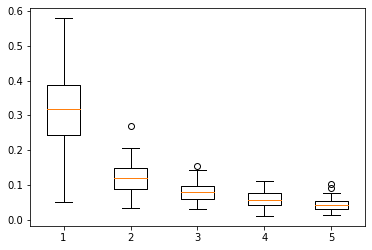

In [ ]:
plt.boxplot(C_25)
plt.show()

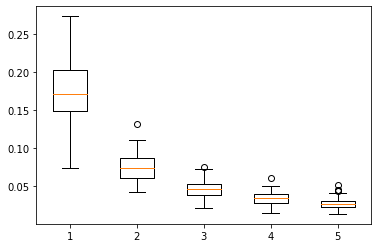

In [ ]:
plt.boxplot(C_5)
plt.show()

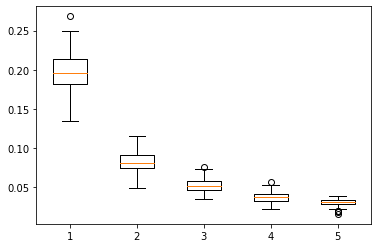

In [ ]:
plt.boxplot(C_10)
plt.show()

In [ ]:
np.random.seed(472)
C_25_new,C_25_new_z=C_calc_sim(2.5,11,25,n=5,c=100)

100%|██████████| 5/5 [00:01<00:00,  3.16it/s]


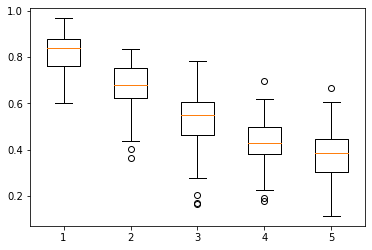

In [ ]:
plt.boxplot(C_25_new)
plt.show()

In [ ]:
np.random.seed(472)
C_5_new,C_5_new_z=C_calc_sim(5,21,90,n=5)

100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


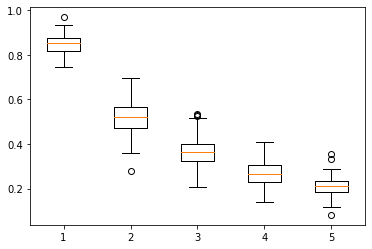

In [ ]:
plt.boxplot(C_5_new)
plt.show()

In [ ]:
all_meansC = np.concatenate((np.mean(np.array(C_25_new),axis=1),
                            np.mean(np.array(C_25),axis=1),
                            np.mean(np.array(C_5_new),axis=1),
                            np.mean(np.array(C_5),axis=1),
                            np.mean(np.array(C_10),axis=1)))

print(all_meansC)

[0.81665945 0.67029302 0.52491226 0.4310371  0.37591952 0.31455931
 0.11985421 0.08034439 0.05812941 0.04322528 0.8513806  0.51738577
 0.36477154 0.26817844 0.21130882 0.17508605 0.07565927 0.04689809
 0.03453986 0.02755917 0.19610138 0.08279609 0.05318375 0.03759982
 0.03066995]


In [ ]:

all_x_values = np.concatenate((np.linspace(11,25,5,dtype='int64',endpoint=True)*0.5/C_25_new_z,
                               np.linspace(30,200,5,dtype='int64',endpoint=True)*0.5/C_25_z,
                               np.linspace(21,90,5,dtype='int64',endpoint=True)*0.5/C_5_new_z,
                               np.linspace(100,700,5,dtype='int64',endpoint=True)*0.5/C_5_z,
                               np.linspace(200,1300,5,dtype='int64',endpoint=True)*0.5/C_10_z))



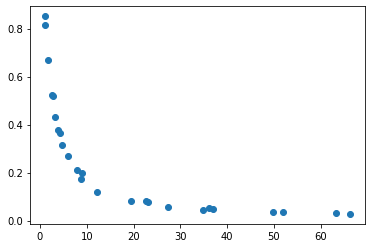

In [ ]:
plt.plot(all_x_values,all_meansC,'o')

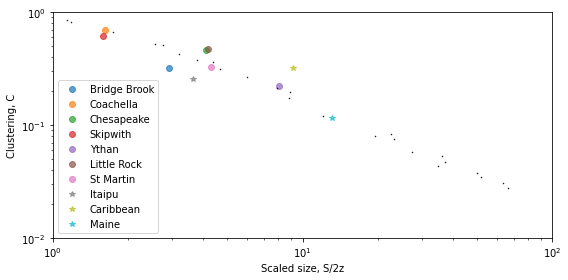

In [ ]:
plt.figure(figsize=(8,4))

plt.plot(brook.S/(2*brook.z),brook.C,'o',label=brook.name,alpha=0.7)
plt.plot(coachella.S/(2*coachella.z),coachella.C,'o',label=coachella.name,alpha=0.7)
plt.plot(chesapeake.S/(2*chesapeake.z),chesapeake.C,'o',label=chesapeake.name,alpha=0.7)
plt.plot(skipwith.S/(2*skipwith.z),skipwith.C,'o',label=skipwith.name,alpha=0.7)
plt.plot(ythan.S/(2*ythan.z),ythan.C,'o',label=ythan.name,alpha=0.7)
plt.plot(rock.S/(2*rock.z),rock.C,'o',label=rock.name,alpha=0.7)
plt.plot(martin.S/(2*martin.z),martin.C,'o',label=martin.name,alpha=0.7)

plt.plot(itaipu.S/(2*itaipu.z),itaipu.C,'*',label=itaipu.name,alpha=0.7)
plt.plot(caribbean.S/(2*caribbean.z),caribbean.C,'*',label=caribbean.name,alpha=0.7)
plt.plot(maine.S/(2*maine.z),maine.C,'*',label=maine.name,alpha=0.7)

plt.plot(all_x_values,all_meansC,'.',color='black',markersize=1)

plt.xscale('log')
plt.yscale('log')
plt.legend()

plt.xlim(1,100)
plt.ylim(0.01,1)

plt.xlabel('Scaled size, S/2z')
plt.ylabel('Clustering, C')

plt.tight_layout()
plt.savefig('Fig4b_2.pdf')
plt.show()